In [1]:
import pandas as pd
import json
import os
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt
%matplotlib inline
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

### Data inladen 

    Load data for town called Ambridge
    data_path = './data/ambridge/'
    review_file = 'review.json'
    business_file = 'business.json'
    user_file = 'user.json'
    tip_file = 'tip.json'
    checkin_file = 'checkin.json'

    reviews = load_jsons(data_path, review_file)
    businesses = load_jsons(data_path, business_file)
    users = load_jsons(data_path, user_file)
    tips = load_jsons(data_path, tip_file)
    checkins = load_jsons(data_path, checkin_file)

In [3]:
data_path = './data/ajax/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)


Text(0.5, 1.0, 'reviews per user')

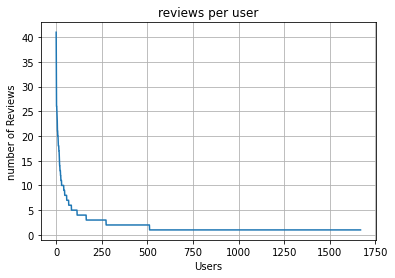

In [4]:
# Reviews per User plot (voor één gebied)

user = reviews.groupby("user_id")  
stars = user['stars']
stars = stars.apply(len)

# Plot
fig, (ax1) = plt.subplots(ncols=1)
ax1.plot(list(stars.sort_values(ascending=False)))
ax1.grid(True)
ax1.set_xlabel("Users")
ax1.set_ylabel("number of Reviews")
ax1.set_title("reviews per user")

In [34]:
def dataframe_BC(businesses):
    " Unpacks categories seprated by a ','  "
    
    dict_id_categorie = businesses[['business_id','categories','stars']]
    
    list_business = []
    list_categories = []
    list_stars = []
    
    for index,row in dict_id_categorie.iterrows():

        if not row['categories'] is None:
            
            for categorie in row['categories'].split(","):
                list_business.append(row['business_id'])
                list_categories.append(categorie)
                list_stars.append(row['stars'])
        
            
    Data = {'business_id': list_business,'categories':list_categories, 'stars': list_stars} 
    BC_dataframe = pd.DataFrame(data=Data)
    return BC_dataframe



def pivot_categories(df):
    "Creates a one-hot encoded matrix for categories."
    return df.pivot_table(index = 'business_id', columns = 'categories', aggfunc = 'size', fill_value=0)
 
    
def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)



def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c["predicted rating"] = to_predict.apply(lambda row: predict_ids(similarity, ratings_test_c, row['user_id'], row["business_id"]),  axis=1)
    return ratings_test_c


### Helper functions for predict_ratings_content_based ###

def predict_ids(similarity, dataframe, userid, businessId):
    
    if businessId in similarity:
    # select right series from matrices and compute
        return predict_vectors(dataframe, userid, similarity[businessId])
    
    return 0


def predict_vectors(user_ratings, userid, similarities):
    
    # select only movies actually rated by user
    selected_user = user_ratings[user_ratings["user_id"] == userid][["business_id", "stars"]]
    
    selected_businesses = selected_user.set_index('business_id')

     
    # select corresponding similairties
    similarities_s = similarities[selected_businesses.index]

    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    

    relevant_ratings = selected_businesses.loc[similarities_s.index]
    

    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
  
    if(norm == 0):
        return 0
    
    similarities_s = pd.DataFrame(data=similarities_s.items(), columns=["business_id", "stars"])

    similarities_s = similarities_s.set_index('business_id')
   
    #compute a weighted average (i.e. neighborhood is all) 
    return np.mean(relevant_ratings['stars'] * similarities_s["stars"])/norm
 

In [35]:
"dataframe hervormen"
dataframe = dataframe_BC(businesses)
display(dataframe)


"Utility matrix"
df_utility_categories = pivot_categories(dataframe)
display(df_utility_categories)


"similarity matrix"
df_similarity_categories = create_similarity_matrix_jaccard(df_utility_categories)
display(df_similarity_categories.head())


"predict ratings"
users = reviews[['user_id', 'business_id', 'stars']]
predicted_rating = predict_ratings(df_similarity_categories, df_utility_categories, users)
display(predicted_rating)


,business_id,categories,stars
0,qxFVwTstR5BuFa4kY50akQ,Comfort Food,3.5
1,qxFVwTstR5BuFa4kY50akQ,Restaurants,3.5
2,qxFVwTstR5BuFa4kY50akQ,American (Traditional),3.5
3,ZDx7kt4aOPTlmYTqXDrTGA,Indian,4.0
4,ZDx7kt4aOPTlmYTqXDrTGA,Restaurants,4.0
...,...,...,...
1102,EgbSLrPqVDIMDpb7FPNEyQ,Active Life,2.5
1103,YbszijctoWpS8FjRbswhEQ,Food,2.0
1104,YbszijctoWpS8FjRbswhEQ,Ice Cream & Frozen Yogurt,2.0
1105,YbszijctoWpS8FjRbswhEQ,Restaurants,2.0


categories,Accessories,Active Life,Afghan,American (New),American (Traditional),Arabian,Arts & Entertainment,Asian Fusion,Auto Detailing,Auto Glass Services,...,Tattoo,Thai,Tires,Tobacco Shops,Toy Stores,Trainers,Transportation,Veterinarians,Windshield Installation & Repair,Women's Clothing
business_id,,,,,,,,,,,,,,,,,,,,,
-4-MzST67P_jnX4mh3MIcw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-YGQwikbX2fXUIjyegR7pw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-_theFeQixeQT_V4xZexQg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
-ldren1EOMh3PkExcpyRoA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-mG8f5khTz8aGVoSCSFmow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zSV2udu2L8-LSqj7-BTbWw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zdT6sB-fsd9Za_cp65himw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zifXaOz_d2dd5QR3d-kTGg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


business_id,-4-MzST67P_jnX4mh3MIcw,-YGQwikbX2fXUIjyegR7pw,-_theFeQixeQT_V4xZexQg,-ldren1EOMh3PkExcpyRoA,-mG8f5khTz8aGVoSCSFmow,0Jyc53wOZt4dbbVPrKjuxA,0P5LEcUbE-Pg8eHnLaBC5Q,0PK7GImBWGwIJ5shGdYB0w,0Tz3J6I9tPIwYpcpgMk6jg,0W-qCKguiieaKQM5Pc75zw,...,ysoRfeir3cl_uKEyLl7Waw,z9ZjlL0hmX45lUWxN4HVDA,zG1VcU3VQnRHxb7nxi313g,zKZLxl3yBN_hVKJS7kEcuA,zKtLlYDnjhoC5siq1A84gw,zSV2udu2L8-LSqj7-BTbWw,zdT6sB-fsd9Za_cp65himw,zifXaOz_d2dd5QR3d-kTGg,zoJZ_LgSBq3YznjrzXkG3Q,zq0_6zcREu5VGSbfqujtMA
business_id,,,,,,,,,,,,,,,,,,,,,
-4-MzST67P_jnX4mh3MIcw,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0
-YGQwikbX2fXUIjyegR7pw,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.142857,0.25,0.2
-_theFeQixeQT_V4xZexQg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0
-ldren1EOMh3PkExcpyRoA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.142857,0.166667,...,0.0,0.0,0.142857,0.0,0.000000,0.1,0.0,0.000000,0.00,0.0
-mG8f5khTz8aGVoSCSFmow,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.2


,user_id,business_id,stars,predicted rating
0,PVPt47alaCdvnr1PAPfu8A,-4-MzST67P_jnX4mh3MIcw,5.0,1.476190
1,BAPHD9v3QOPnZTILIsNmmA,V84YoNmnXlp3EK50jWSFpA,1.0,1.000000
2,vN5zGsljpV_LmBEAfhjDvA,sSWy-yEYPCHLss0LvmAhhA,4.0,0.541462
3,5DCrTNKPpGBOJORIRu7SYQ,dBNZXjBw6w6l9QBj34BiFw,4.0,4.000000
4,zFGpxwJewI6OjC2u9EnZ-g,-4-MzST67P_jnX4mh3MIcw,5.0,1.496774
...,...,...,...,...
3283,qIIWAMJ_LwlJi0fntUpsjg,_f6AQfqMkhN17Oe7dhoubw,5.0,5.000000
3284,gDLIDZfxRLtKHIvI4CGhCQ,632tj67V8Oqdh56elNvFng,2.0,2.000000
3285,Jmn3VidgLi7nJDifzE6dgg,lyX-_zyEHDYNodWL-ZXlnQ,5.0,5.000000
3286,vVHVLgvh2hSsglO4uGSEVg,632tj67V8Oqdh56elNvFng,1.0,0.373987
